# Import lib

In [2]:
import pandas as pd
import os
from dotenv import load_dotenv
load_dotenv()
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns


In [3]:
df_klaim = pd.read_csv('../dataset/Data_Klaim.csv')
df_polis = pd.read_csv('../dataset/Data_Polis.csv')
df = pd.merge(df_klaim, df_polis, on="Nomor Polis", how="left")

# Convert date columns to datetime
date_cols = ['Tanggal Pasien Masuk RS', 'Tanggal Pasien Keluar RS', 'Tanggal Pembayaran Klaim']
for col in date_cols:
    if col in df_klaim.columns:
        df_klaim[col] = pd.to_datetime(df_klaim[col], errors='coerce')

print("✓ Data loaded and dates converted")

✓ Data loaded and dates converted


# Cek Feature

In [6]:
df_klaim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4627 entries, 0 to 4626
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Claim ID                       4627 non-null   object        
 1   Nomor Polis                    4627 non-null   object        
 2   Reimburse/Cashless             4627 non-null   object        
 3   Inpatient/Outpatient           4590 non-null   object        
 4   ICD Diagnosis                  4621 non-null   object        
 5   ICD Description                4621 non-null   object        
 6   Status Klaim                   4627 non-null   object        
 7   Tanggal Pembayaran Klaim       4590 non-null   datetime64[ns]
 8   Tanggal Pasien Masuk RS        4627 non-null   datetime64[ns]
 9   Tanggal Pasien Keluar RS       4627 non-null   datetime64[ns]
 10  Nominal Klaim Yang Disetujui   4627 non-null   float64       
 11  Nominal Biaya RS 

In [9]:
df_polis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4096 entries, 0 to 4095
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Nomor Polis            4096 non-null   object
 1   Plan Code              4096 non-null   object
 2   Gender                 4096 non-null   object
 3   Tanggal Lahir          4096 non-null   int64 
 4   Tanggal Efektif Polis  4096 non-null   int64 
 5   Domisili               4096 non-null   object
dtypes: int64(2), object(4)
memory usage: 192.1+ KB


# Pengelompokan

In [7]:
# 1. Pengelompokan Data Berdasarkan Bulan
# Pastikan kolom date sudah datetime
if df_klaim['Tanggal Pasien Masuk RS'].dtype == 'object':
    df_klaim['Tanggal Pasien Masuk RS'] = pd.to_datetime(df_klaim['Tanggal Pasien Masuk RS'], errors='coerce')

df_klaim['year_month'] = df_klaim['Tanggal Pasien Masuk RS'].dt.to_period('M')

# 2. Menghitung Tiga Metrik Utama per Bulan
df_monthly = df_klaim.groupby('year_month').agg({
    'Claim ID': 'nunique',  # Target 1: Frekuensi (jumlah klaim unik)
    'Nominal Klaim Yang Disetujui': 'sum'  # Target 2: Total Claim
}).reset_index()

# Rename kolom
df_monthly.columns = ['year_month', 'Claim_Frequency', 'Total_Claim']

# Target 3: Severitas (rata-rata nilai per klaim)
df_monthly['Claim_Severity'] = df_monthly['Total_Claim'] / df_monthly['Claim_Frequency']

# Konversi year_month ke datetime untuk visualisasi
df_monthly['date'] = df_monthly['year_month'].dt.to_timestamp()

print("✓ Grouping selesai")
df_monthly

✓ Grouping selesai


,year_month,Claim_Frequency,Total_Claim,Claim_Severity,date
0,2024-01,302,2.026098e+10,6.708934e+07,2024-01-01
1,2024-02,208,1.385965e+10,6.663291e+07,2024-02-01
2,2024-03,278,1.431126e+10,5.147935e+07,2024-03-01
3,2024-04,239,1.144106e+10,4.787056e+07,2024-04-01
4,2024-05,263,1.221146e+10,4.643141e+07,2024-05-01
5,2024-06,225,1.212517e+10,5.388963e+07,2024-06-01
6,2024-07,257,1.497052e+10,5.825104e+07,2024-07-01
7,2024-08,228,1.351294e+10,5.926726e+07,2024-08-01
8,2024-09,208,1.226412e+10,5.896211e+07,2024-09-01
9,2024-10,274,1.268117e+10,4.628163e+07,2024-10-01


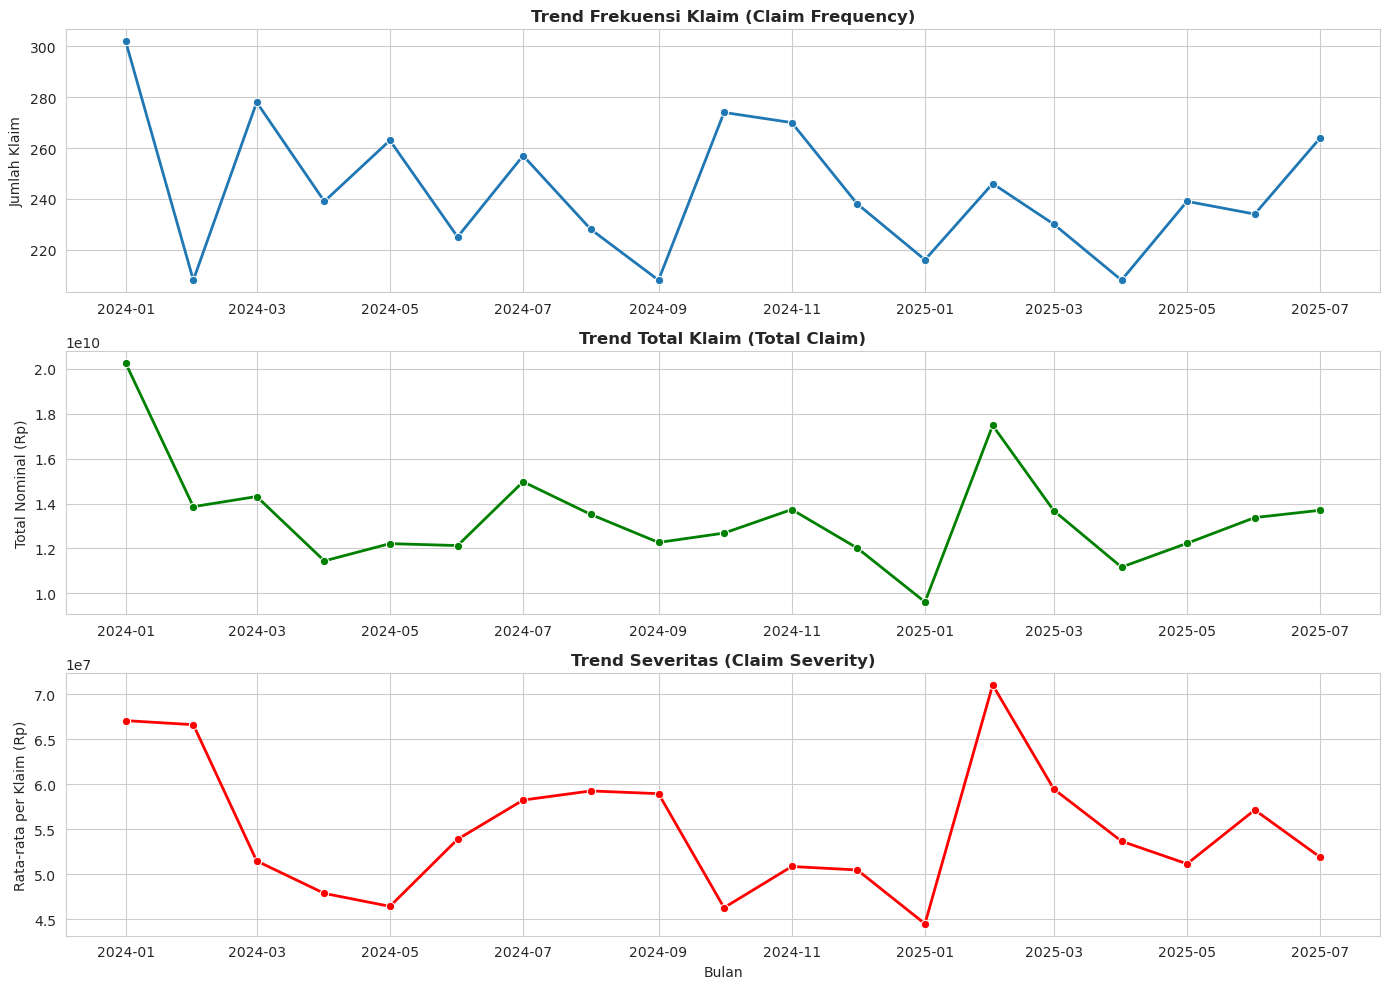

In [8]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Plot 1: Frekuensi Klaim
sns.lineplot(data=df_monthly, x='date', y='Claim_Frequency', marker='o', linewidth=2, ax=axes[0])
axes[0].set_title('Trend Frekuensi Klaim (Claim Frequency)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Jumlah Klaim')
axes[0].set_xlabel('')

# Plot 2: Total Klaim
sns.lineplot(data=df_monthly, x='date', y='Total_Claim', marker='o', color='green', linewidth=2, ax=axes[1])
axes[1].set_title('Trend Total Klaim (Total Claim)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Total Nominal (Rp)')
axes[1].set_xlabel('')

# Plot 3: Severitas
sns.lineplot(data=df_monthly, x='date', y='Claim_Severity', marker='o', color='red', linewidth=2, ax=axes[2])
axes[2].set_title('Trend Severitas (Claim Severity)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Rata-rata per Klaim (Rp)')
axes[2].set_xlabel('Bulan')

plt.tight_layout()
plt.show()

In [9]:
# Cek distribusi status klaim per bulan
df_klaim.groupby(['year_month', 'Status Klaim']).size().unstack(fill_value=0)

Status Klaim,PAID
year_month,
2024-01,302
2024-02,208
2024-03,278
2024-04,239
2024-05,263
2024-06,225
2024-07,257
2024-08,228
2024-09,208


# Missing value

In [10]:
# Cek missing value Data Klaim
print("=== Missing Values - Data Klaim ===")
missing_klaim = df_klaim.isnull().sum()
missing_klaim_pct = (df_klaim.isnull().sum() / len(df_klaim) * 100).round(2)
pd.DataFrame({
    'Missing Count': missing_klaim,
    'Percentage (%)': missing_klaim_pct
}).sort_values('Missing Count', ascending=False)

=== Missing Values - Data Klaim ===


,Missing Count,Percentage (%)
Inpatient/Outpatient,37,0.80
Tanggal Pembayaran Klaim,37,0.80
Lokasi RS,7,0.15
ICD Diagnosis,6,0.13
ICD Description,6,0.13
Claim ID,0,0.00
Reimburse/Cashless,0,0.00
Nomor Polis,0,0.00
Tanggal Pasien Masuk RS,0,0.00
Status Klaim,0,0.00


In [ ]:
df_klaim.isna().sum().sum()

np.int64(130)

In [ ]:
df_klaim.dropna(inplace=True)

In [11]:
# Cek missing value Data Polis
print("\n=== Missing Values - Data Polis ===")
missing_polis = df_polis.isnull().sum()
missing_polis_pct = (df_polis.isnull().sum() / len(df_polis) * 100).round(2)
pd.DataFrame({
    'Missing Count': missing_polis,
    'Percentage (%)': missing_polis_pct
}).sort_values('Missing Count', ascending=False)


=== Missing Values - Data Polis ===


,Missing Count,Percentage (%)
Nomor Polis,0,0.0
Plan Code,0,0.0
Gender,0,0.0
Tanggal Lahir,0,0.0
Tanggal Efektif Polis,0,0.0
Domisili,0,0.0
